# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [90]:
# student 1: Ofir 9239
# student 2: Avi 3420
# student 2: Mor 8306

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [114]:
house_train = pd.read_csv("housing_train.csv")
house_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,4.0179,46.0,4.158690,1.032746,512.0,1.289673,34.07,-118.35,3.500
1,2.7002,6.0,4.149245,1.179989,4092.0,2.287311,34.05,-117.31,0.883
2,1.2762,17.0,3.432331,1.022556,1325.0,2.490602,34.42,-119.69,2.536
3,4.9342,23.0,5.735798,1.053201,4580.0,4.129847,34.04,-117.93,1.810
4,2.2755,21.0,4.064607,0.962079,2109.0,2.962079,32.58,-117.11,1.250


In [115]:
house_test = pd.read_csv("housing_test.csv")
house_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,5.3254,32.0,5.786260,1.033079,982.0,2.498728,34.29,-119.27,3.852
1,5.3032,52.0,5.095745,1.028369,980.0,3.475177,34.08,-118.12,2.457
2,4.1679,41.0,6.617486,1.371585,915.0,2.500000,37.05,-122.05,2.013
3,3.6429,28.0,5.249180,1.009836,848.0,2.780328,38.69,-121.41,1.052
4,2.7457,17.0,11.183267,2.107570,675.0,2.689243,38.88,-119.99,1.078



Descriptive Statistics for the Training Dataset:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  16512.000000  16512.000000  16512.000000  16512.000000  16512.000000   
mean       3.863517     28.650678      5.412479      1.093546   1424.287609   
std        1.878577     12.623994      2.088680      0.378594   1139.012630   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.564375     18.000000      4.448665      1.005988    789.000000   
50%        3.536650     29.000000      5.225511      1.048780   1167.000000   
75%        4.744375     37.000000      6.046629      1.099691   1722.000000   
max       15.000100     52.000000     62.422222     15.312500  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  16512.000000  16512.000000  16512.000000  16512.000000  
mean       3.101201     35.631452   -119.566283      2.065267  
std       11.587773      2.137537      2.00655

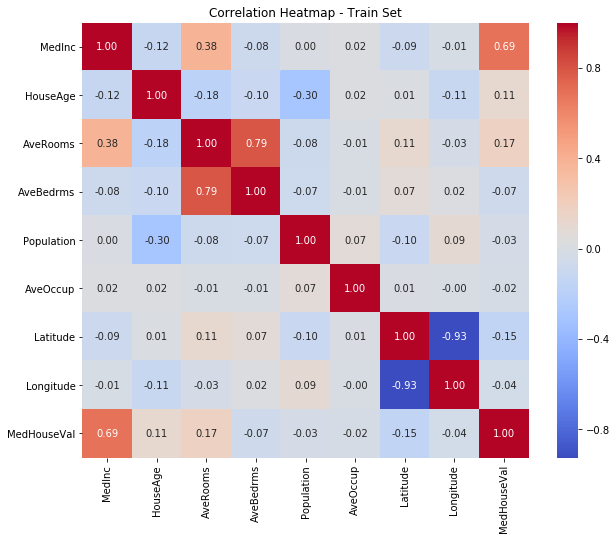

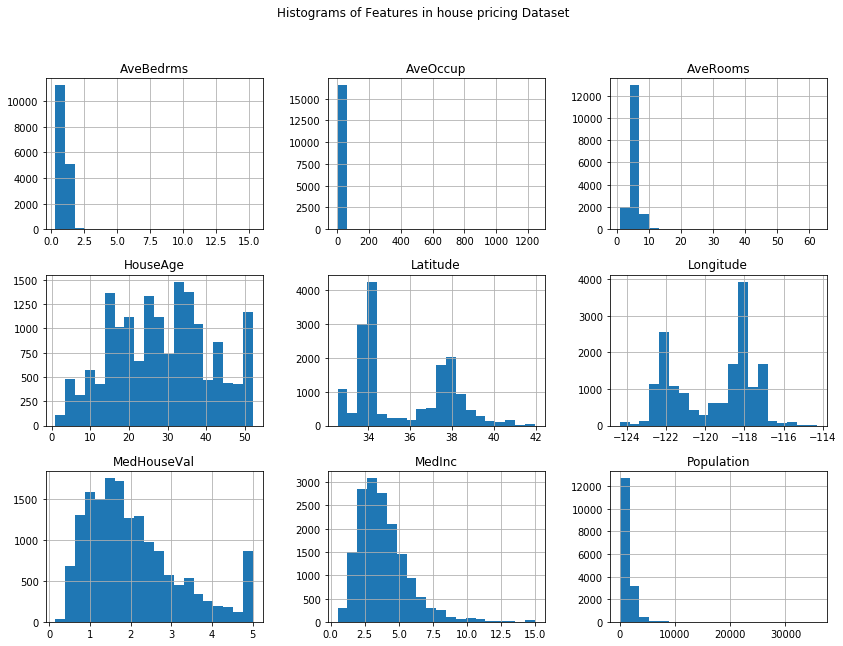

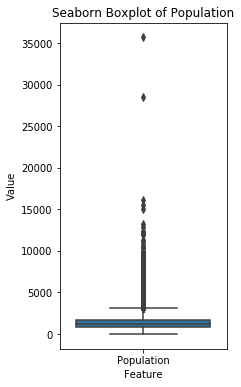

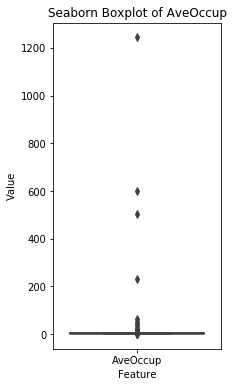

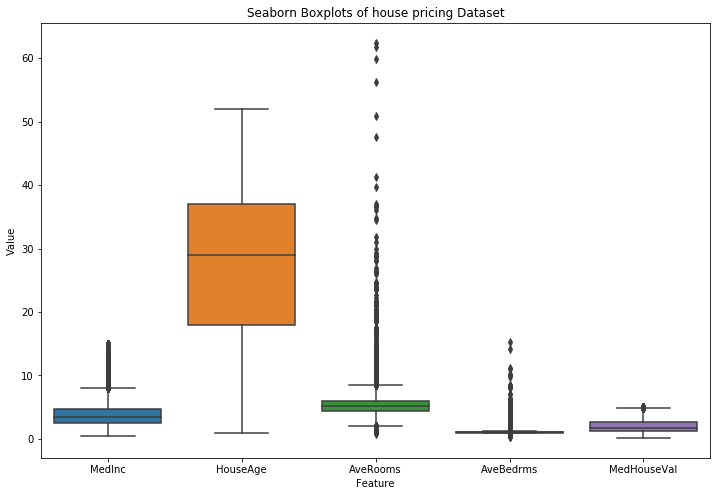

In [116]:
# Descriptive statistics
train_statistics = house_train.describe()
print("\nDescriptive Statistics for the Training Dataset:")
print(train_statistics)

# Correlation Heatmap - 
plt.figure(figsize=(10, 8))
sns.heatmap(house_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap - Train Set')
plt.show()

# Histograms
house_train.hist(bins=20, figsize=(14, 10))
plt.suptitle('Histograms of Features in house pricing Dataset')
plt.show()

# Boxplots:
# 1. Population:
features = ['Population']
melted_data = house_train[features].melt(var_name='Feature', value_name='Value')
plt.figure(figsize=(3, 6))
sns.boxplot(x='Feature', y='Value', data=melted_data)
plt.title('Seaborn Boxplot of Population')
plt.show()

# 2. AveOccup
features = ['AveOccup']
melted_data = house_train[features].melt(var_name='Feature', value_name='Value')
plt.figure(figsize=(3, 6))
sns.boxplot(x='Feature', y='Value', data=melted_data)
plt.title('Seaborn Boxplot of AveOccup')
plt.show()

# 3. Rest of the Dataset
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'MedHouseVal']
melted_data = house_train[features].melt(var_name='Feature', value_name='Value')
plt.figure(figsize=(12, 8))
sns.boxplot(x='Feature', y='Value', data=melted_data)
plt.title('Seaborn Boxplots of house pricing Dataset')
plt.show()

## Part 3 - Experiments
בשלב זה ביצענו ניסויים עם 2 מערכי נתונים שונים - אחד שעבר ניקוי של חריגים ב-2 עמודות, והשני עם מערך הנתונים הרגיל.
עבור כל אחד מהם בוצעו ניסויים עם 3 סקיילרים שכל אחד מהם מבצע שינוי משלו על הנתונים.
בחרנו ב-3 אלגוריתמי למידה עם היפר פרמטרים שונים כך שסך הכל ביצענו 18 ניסויים.
המודלים שנבחרו הם:
1. Random Forest
2. Linear Regression
3. KNN


עבור כל אחד מהניסויים הדפסנו את התוצאות שלו תוך בדיקה מה התוצאה הכללית הטובה ביותר שעל פיה עברנו לשלב הבא

In [117]:
def remove_outliers_iqr(df, column, iqr_multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [118]:
def evaluate(model_grid, X_train, y_train, model_details, scaler_name, dataset_type):
    model_grid.fit(X_train, y_train)
    
    title = f"{model_details} - {scaler_name} - {dataset_type}"
    print(f"\n{title:^80}")
    print("=" * 80)
    
    results_df = pd.DataFrame(model_grid.cv_results_)
    display_df = results_df[['params', 'mean_test_score', 'std_test_score']].copy()
    display_df['mean_test_score'] = display_df['mean_test_score'].apply(lambda x: f"{x:.4f}")
    display_df['std_test_score'] = display_df['std_test_score'].apply(lambda x: f"{x:.4f}")
    display_df.columns = ['Parameters', 'CV R² Score', 'Mean R² Score']
    
    display(display_df.style.set_properties(**{'text-align': 'center'})
                      .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))

    result = {
        'Model': model_details,
        'Scaler': scaler_name,
        'Dataset': dataset_type,
        'Best Params': model_grid.best_params_,
        'Best R² Score': model_grid.best_score_
    }
    
    return result

In [119]:
# make use 2 options of data types

house_train_cleaned = remove_outliers_iqr(house_train, 'MedInc')
house_train_cleaned = remove_outliers_iqr(house_train_cleaned, 'MedHouseVal')

X_train = house_train.drop(columns=['MedHouseVal'])
y_train = house_train['MedHouseVal']  

X_train_cleaned = house_train_cleaned.drop(columns=['MedHouseVal'])
y_train_cleaned = house_train_cleaned['MedHouseVal']

In [120]:
# Define scalers and Model parameters
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

rf_params = {
    'RF-Regressor__n_estimators': [100, 200],
    'RF-Regressor__max_depth': [10, 20, None]
}

knn_params = {
    'KNN-Regressor__n_neighbors': [3, 5, 7, 9],
    'KNN-Regressor__weights': ['uniform', 'distance']
}

In [122]:
results_summary = pd.DataFrame(columns=['Model', 'Scaler', 'Dataset', 'Best Params', 'Best R² Score'])

best_result = None
best_score = -np.inf

# Run experiments for each model with each scaler
for scaler_name, scaler in scalers.items():
    # Random Forest
    rf_pipeline = Pipeline([('scaler', scaler), ('RF-Regressor', RandomForestRegressor())])
    rf_GS = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='r2', n_jobs=3)
    
    result = evaluate(rf_GS, X_train_cleaned, y_train_cleaned, 'Random Forest', scaler_name, 'Cleaned Dataset')
    results_summary = results_summary.append(result, ignore_index=True)
    if result['Best R² Score'] > best_score:
        best_score = result['Best R² Score']
        best_result = result
    
    result = evaluate(rf_GS, X_train, y_train, 'Random Forest', scaler_name, 'Original Dataset')
    results_summary = results_summary.append(result, ignore_index=True)
    if result['Best R² Score'] > best_score:
        best_score = result['Best R² Score']
        best_result = result
    
    # K-Nearest Neighbors
    knn_pipeline = Pipeline([('scaler', scaler), ('KNN-Regressor', KNeighborsRegressor())])
    knn_GS = GridSearchCV(knn_pipeline, knn_params, cv=5, scoring='r2', n_jobs=2)
    
    result = evaluate(knn_GS, X_train_cleaned, y_train_cleaned, 'K-Nearest Neighbors', scaler_name, 'Cleaned Dataset')
    results_summary = results_summary.append(result, ignore_index=True)
    if result['Best R² Score'] > best_score:
        best_score = result['Best R² Score']
        best_result = result
    
    result = evaluate(knn_GS, X_train, y_train, 'K-Nearest Neighbors', scaler_name, 'Original Dataset')
    results_summary = results_summary.append(result, ignore_index=True)
    if result['Best R² Score'] > best_score:
        best_score = result['Best R² Score']
        best_result = result
    
    # Linear Regression
    lr_pipeline = Pipeline([('scaler', scaler), ('LRegressor', LinearRegression())])
    lr_GS = GridSearchCV(lr_pipeline, {}, cv=5, scoring='r2', n_jobs=-1)
    
    result = evaluate(lr_GS, X_train_cleaned, y_train_cleaned, 'Linear Regression', scaler_name, 'Cleaned Dataset')
    results_summary = results_summary.append(result, ignore_index=True)
    if result['Best R² Score'] > best_score:
        best_score = result['Best R² Score']
        best_result = result
    
    result = evaluate(lr_GS, X_train, y_train, 'Linear Regression', scaler_name, 'Original Dataset')
    results_summary = results_summary.append(result, ignore_index=True)
    if result['Best R² Score'] > best_score:
        best_score = result['Best R² Score']
        best_result = result

# Display all results
print("\nAll Results:")
display(results_summary)

# Print the best result
print("\nBest Result:")
print(f"Model: {best_result['Model']}")
print(f"Scaler: {best_result['Scaler']}")
print(f"Dataset: {best_result['Dataset']}")
print(f"Best Parameters: {best_result['Best Params']}")
print(f"Best R² Score: {best_result['Best R² Score']}")


                Random Forest - StandardScaler - Cleaned Dataset                


,Parameters,CV R² Score,Mean R² Score
0,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 100}",0.7337,0.0113
1,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 200}",0.7345,0.0116
2,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 100}",0.7610,0.0093
3,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 200}",0.7634,0.0096
4,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 100}",0.7623,0.0106
5,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 200}",0.7635,0.0100



               Random Forest - StandardScaler - Original Dataset                


,Parameters,CV R² Score,Mean R² Score
0,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 100}",0.7747,0.0116
1,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 200}",0.7753,0.0119
2,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 100}",0.7971,0.0096
3,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 200}",0.7990,0.0103
4,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 100}",0.7978,0.0111
5,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 200}",0.7987,0.0107



             K-Nearest Neighbors - StandardScaler - Cleaned Dataset             


,Parameters,CV R² Score,Mean R² Score
0,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'uniform'}",0.5996,0.0196
1,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'distance'}",0.6026,0.0199
2,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'uniform'}",0.6253,0.0183
3,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'distance'}",0.6298,0.0184
4,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'uniform'}",0.6364,0.0177
5,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'distance'}",0.6413,0.0176
6,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'uniform'}",0.6393,0.0163
7,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'distance'}",0.6447,0.0165



            K-Nearest Neighbors - StandardScaler - Original Dataset             


,Parameters,CV R² Score,Mean R² Score
0,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'uniform'}",0.6447,0.0176
1,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'distance'}",0.6469,0.0173
2,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'uniform'}",0.6693,0.0183
3,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'distance'}",0.6726,0.0183
4,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'uniform'}",0.6763,0.0174
5,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'distance'}",0.6806,0.0175
6,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'uniform'}",0.6797,0.0178
7,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'distance'}",0.6843,0.0178



              Linear Regression - StandardScaler - Cleaned Dataset              


,Parameters,CV R² Score,Mean R² Score
0,{},0.5601,0.0095



             Linear Regression - StandardScaler - Original Dataset              


,Parameters,CV R² Score,Mean R² Score
0,{},0.6048,0.0126



                 Random Forest - MinMaxScaler - Cleaned Dataset                 


,Parameters,CV R² Score,Mean R² Score
0,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 100}",0.7345,0.0107
1,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 200}",0.7344,0.0125
2,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 100}",0.7624,0.0102
3,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 200}",0.7632,0.0093
4,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 100}",0.7611,0.0097
5,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 200}",0.7634,0.0090



                Random Forest - MinMaxScaler - Original Dataset                 


,Parameters,CV R² Score,Mean R² Score
0,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 100}",0.7745,0.0133
1,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 200}",0.7751,0.0122
2,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 100}",0.7984,0.0094
3,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 200}",0.7989,0.0099
4,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 100}",0.7985,0.0092
5,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 200}",0.7989,0.0105



              K-Nearest Neighbors - MinMaxScaler - Cleaned Dataset              


,Parameters,CV R² Score,Mean R² Score
0,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'uniform'}",0.5903,0.0122
1,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'distance'}",0.5931,0.0117
2,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'uniform'}",0.6183,0.0144
3,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'distance'}",0.6230,0.0133
4,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'uniform'}",0.6268,0.0146
5,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'distance'}",0.6330,0.0137
6,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'uniform'}",0.6318,0.0129
7,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'distance'}",0.6385,0.0124



             K-Nearest Neighbors - MinMaxScaler - Original Dataset              


,Parameters,CV R² Score,Mean R² Score
0,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'uniform'}",0.6699,0.0079
1,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'distance'}",0.6726,0.0070
2,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'uniform'}",0.6918,0.0125
3,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'distance'}",0.6961,0.0116
4,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'uniform'}",0.6967,0.0126
5,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'distance'}",0.7020,0.0118
6,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'uniform'}",0.6983,0.0128
7,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'distance'}",0.7044,0.0122



               Linear Regression - MinMaxScaler - Cleaned Dataset               


,Parameters,CV R² Score,Mean R² Score
0,{},0.5601,0.0095



              Linear Regression - MinMaxScaler - Original Dataset               


,Parameters,CV R² Score,Mean R² Score
0,{},0.6048,0.0126



                 Random Forest - RobustScaler - Cleaned Dataset                 


,Parameters,CV R² Score,Mean R² Score
0,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 100}",0.7328,0.0119
1,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 200}",0.7334,0.0116
2,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 100}",0.7612,0.0087
3,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 200}",0.7639,0.0100
4,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 100}",0.7604,0.0092
5,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 200}",0.7636,0.0091



                Random Forest - RobustScaler - Original Dataset                 


,Parameters,CV R² Score,Mean R² Score
0,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 100}",0.7732,0.0127
1,"{'RF-Regressor__max_depth': 10, 'RF-Regressor__n_estimators': 200}",0.7756,0.0120
2,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 100}",0.7985,0.0113
3,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 200}",0.7995,0.0091
4,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 100}",0.7987,0.0092
5,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 200}",0.7993,0.0100



              K-Nearest Neighbors - RobustScaler - Cleaned Dataset              


,Parameters,CV R² Score,Mean R² Score
0,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'uniform'}",0.5647,0.0086
1,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'distance'}",0.5665,0.0088
2,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'uniform'}",0.6001,0.0124
3,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'distance'}",0.6026,0.0120
4,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'uniform'}",0.6130,0.0095
5,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'distance'}",0.6163,0.0096
6,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'uniform'}",0.6190,0.0102
7,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'distance'}",0.6229,0.0101



             K-Nearest Neighbors - RobustScaler - Original Dataset              


,Parameters,CV R² Score,Mean R² Score
0,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'uniform'}",0.6465,0.0148
1,"{'KNN-Regressor__n_neighbors': 3, 'KNN-Regressor__weights': 'distance'}",0.6483,0.0147
2,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'uniform'}",0.6734,0.0134
3,"{'KNN-Regressor__n_neighbors': 5, 'KNN-Regressor__weights': 'distance'}",0.6764,0.0134
4,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'uniform'}",0.6849,0.0135
5,"{'KNN-Regressor__n_neighbors': 7, 'KNN-Regressor__weights': 'distance'}",0.6883,0.0134
6,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'uniform'}",0.6881,0.0127
7,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'distance'}",0.6921,0.0127



               Linear Regression - RobustScaler - Cleaned Dataset               


,Parameters,CV R² Score,Mean R² Score
0,{},0.5601,0.0095



              Linear Regression - RobustScaler - Original Dataset               


,Parameters,CV R² Score,Mean R² Score
0,{},0.6048,0.0126



All Results:


,Model,Scaler,Dataset,Best Params,Best R² Score
0,Random Forest,StandardScaler,Cleaned Dataset,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 200}",0.763509
1,Random Forest,StandardScaler,Original Dataset,"{'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 200}",0.798979
2,K-Nearest Neighbors,StandardScaler,Cleaned Dataset,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'distance'}",0.644681
3,K-Nearest Neighbors,StandardScaler,Original Dataset,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'distance'}",0.684285
4,Linear Regression,StandardScaler,Cleaned Dataset,{},0.560149
5,Linear Regression,StandardScaler,Original Dataset,{},0.604825
6,Random Forest,MinMaxScaler,Cleaned Dataset,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 200}",0.763416
7,Random Forest,MinMaxScaler,Original Dataset,"{'RF-Regressor__max_depth': None, 'RF-Regressor__n_estimators': 200}",0.798950
8,K-Nearest Neighbors,MinMaxScaler,Cleaned Dataset,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'distance'}",0.638514
9,K-Nearest Neighbors,MinMaxScaler,Original Dataset,"{'KNN-Regressor__n_neighbors': 9, 'KNN-Regressor__weights': 'distance'}",0.704374



Best Result:
Model: Random Forest
Scaler: RobustScaler
Dataset: Original Dataset
Best Parameters: {'RF-Regressor__max_depth': 20, 'RF-Regressor__n_estimators': 200}
Best R² Score: 0.7995169059958745


## Part 4 - Training 
המודל הנבחר יחד עם שאר הפרמטרים הודפסו בסוף החלק הקודם, כעת נשתמש בהם לאימון מחדש.

In [124]:
housing_train = pd.read_csv('housing_train.csv')

X = housing_train.drop('MedHouseVal', axis=1)
y = housing_train['MedHouseVal']

# Create the pipeline with RobustScaler and RandomForestRegressor
model = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=20))
])

model.fit(X, y)

print("Complete Training")

Complete Training


## Part 5 - Apply on test and show model performance estimation

ביצוע חיזוי על קובץ הבדיקה.

לאחר מכן הדפסה של 5 החיזויים הראשונים ותוצאת הבדיקה ב-r2

In [125]:
housing_test = pd.read_csv('housing_test.csv')

X_test = housing_test.drop('MedHouseVal', axis=1)
y_test = housing_test['MedHouseVal']

test_predictions = model.predict(X_test)

print("First 5 predictions vs actual values:")
for pred, actual in zip(test_predictions[:5], y_test[:5]):
    print(f"Predicted: {pred:.2f}, Actual: {actual:.2f}")

test_r2 = r2_score(y_test, test_predictions)
print(f"\nTest R² Score: {test_r2:.4f}")

First 5 predictions vs actual values:
Predicted: 3.33, Actual: 3.85
Predicted: 2.33, Actual: 2.46
Predicted: 2.70, Actual: 2.01
Predicted: 1.14, Actual: 1.05
Predicted: 1.22, Actual: 1.08

Test R² Score: 0.8273
